In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
from collections import Counter
import matplotlib
import scipy

In [2]:
gpus = tf.config.experimental.list_physical_devices( device_type = 'GPU' )
# 设置该程序可见的GPU：写到最前面！
tf.config.experimental.set_visible_devices( devices = gpus[2:4], device_type = 'GPU' )

In [3]:
model = tf.keras.models.load_model( 'model12_450_调过拟合.h5' )

In [11]:
# 读取图片：3通道
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 3)
    return img

In [17]:
# 用当前模型测试一张图：
img_test = glob.glob( r'/home/gaoboyu/学习数据集/原图分割后/*' )
total = len(img_test)
img = []
label = [] 

for x in range(total):
    # 从路径读取图像：
    tmp = read_image( img_test[x] )
    # 拓展一维：变成“批次”形式！
    tmp = tf.cast(tmp, tf.float32) / 127.5 - 1  # 归到[-1,1]之间！—— 和输入数据一致！
    tmp = tf.expand_dims( tmp, axis = 0 )
    # 标签预测：
    label_pred = model.predict(tmp)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！
    # 恢复原形：
    tmp = tf.squeeze( tmp, axis = 0 )
    # 存：
    img.append( tmp )
    label.append( label_pred )

In [13]:
# plt.figure( figsize=(20,20) )
# for x in range( 10 ):
#     plt.subplot(total, 2, x*2 + 1)
#     plt.imshow( (img[x].numpy() + 1)/2 )
#     plt.subplot(total, 2, x*2 + 2)
#     plt.imshow( label[x].numpy().reshape(256,256) )

In [18]:
# 全部转为numpy：
for x in range(total):
    # img[x] = img[x].numpy()
    label[x] = label[x].numpy()  # 转为数组
    label[x] = np.squeeze( label[x], axis = 0 )

In [31]:
# 保存：
index = [ int(x.split('/')[-1].split('.')[0].split('_')[-1]) for x in img_test ]
index = sorted(index)
save_path = '/home/gaoboyu/学习数据集/预测结果/'
for x in range(total):
    plt.imsave( save_path + 'label_{}.png'.format( index[x] ), label[x] )

### 2. 把所有预测结果合并为一张图：

In [4]:
row_total, col_total = (56, 94)

In [8]:
# 图像拼合函数2：读取子图文件，返回合并后的一张大图
# 输入：无；  输出：一张合并好的图像
# 合并方式：同recoverimg1，只需多生成一个img_split即可
def recoverimg2():
    
    # 所有子图的地址：
    # 地址文件需要排序（提取那个“数值”）：原始的是1, 10, 100 ...
    all_image_path = glob.glob( r'/home/gaoboyu/学习数据集/预测结果/*' )  # 每次改这里！
    all_image_path = sorted(all_image_path, key = lambda x:int(x.split('/')[-1].split('.')[0].split('_')[-1]) )  # 记得加int!
    total = len(all_image_path)
    
    # 生成img_split
    img_split = [] 
    for x in range(total):
        img = tf.io.read_file(all_image_path[x])
        img = tf.image.decode_png(img, channels = 1)
        img = img.numpy()
        #img = matplotlib.image.imread(all_image_path[x], format = 'PNG')  # 读取文件并解码：返回的是数组！
        #img = img[:,:,0:1]    # 最后的一个“透明度”通道去掉
        img_split.append(img)
     
    # 合并：
    # 每行合并：
    img_row = [] 
    for x in range(row_total):
        tmp = np.concatenate( img_split[x*col_total:(x+1)*col_total], axis = 1 )
        img_row.append(tmp)  # 共10行，故共10个合并后的元素  
    # 所有行合并：
    img_recover = np.concatenate(img_row, axis = 0)
    
    return img_recover

In [9]:
img_recover2 = recoverimg2()

In [10]:
img_recover2.shape

(14336, 24064, 1)

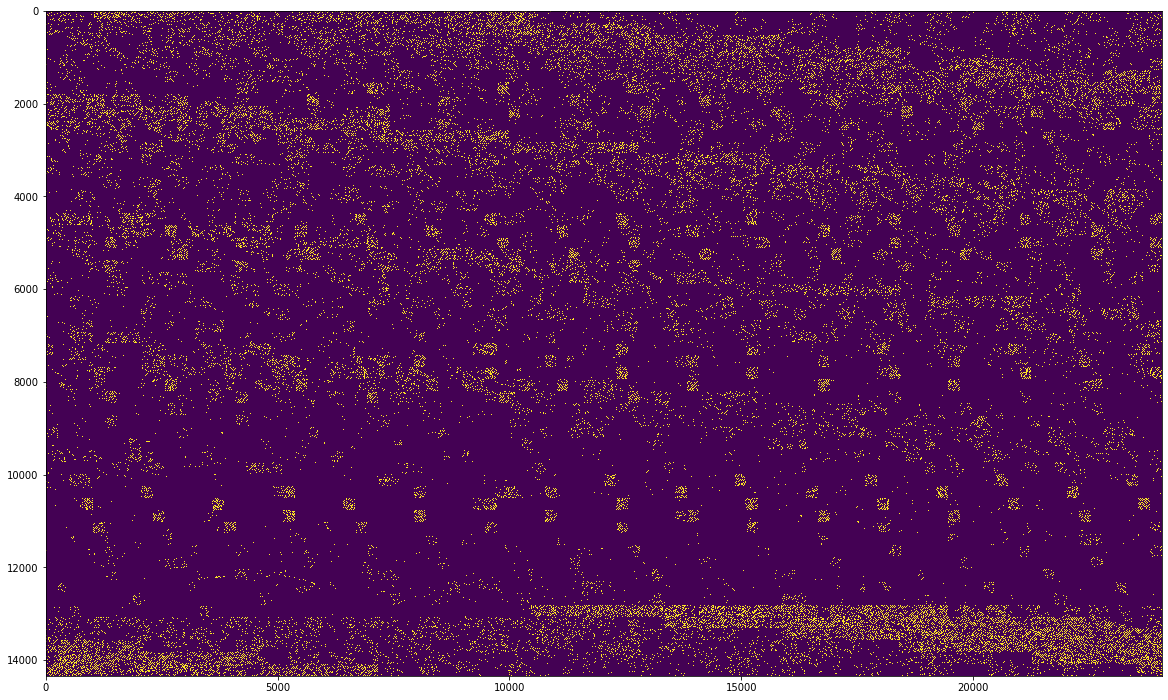

In [17]:
plt.figure( figsize = (20,20) )
plt.imshow( img_recover2.reshape(14336, 24064) )

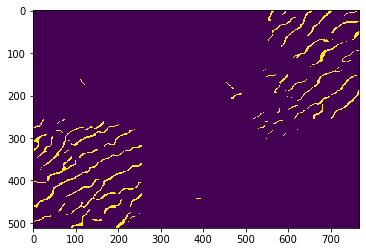

In [49]:
plt.imshow( img_recover2[256*23:256*25, 256*13:256*16] )

In [16]:
hebing_path = '/home/gaoboyu/学习数据集/预测结果/'
# plt.imsave(hebing_path, img_recover2[:,:])
import scipy.misc
scipy.misc.toimage(img_recover2).save( hebing_path + 'outfile.jpg')

AttributeError: module 'scipy.misc' has no attribute 'toimage'